<a href="https://colab.research.google.com/github/mathewsjob/Master-Thesis/blob/main/extract_features_31-10-2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Necessary packages**

In [1]:
import os, shutil
from google.colab import drive

In [9]:
import numpy as np
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import InceptionV3

**Mounting Drive**

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
batch_size = 32
img_height = 244
img_width = 244

**Setting Path**

In [46]:
base_dir = '/content/drive/My Drive/training_set'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
data_dir = train_dir

In [16]:
os.listdir(train_dir)

['ulcerative-colitis',
 'polyps',
 'normal-z-line',
 'normal-pylorus',
 'normal-cecum',
 'esophagitis',
 'dyed-resection-margins',
 'dyed-lifted-polyps']

**Get Categories(Class) of Dataset**

In [17]:
def get_dataCategories(directory):
    """
        get the categories (class) of the dataset from the path of the dataset
        in question.

    args:
        dataset_dir (str): dataset path

    Returns:
        list: list of categories
        list: list of number of files by categories
    """
    import glob

    categories = []
    for folder_name in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(directory, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])



directory = train_dir
categories, nbr_files = get_dataCategories(directory)

# Create DataFrame
df = pd.DataFrame({"categories": categories, "number of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  8


,categories,number of files
0,dyed-lifted-polyps,2000
1,dyed-resection-margins,2000
2,esophagitis,2000
3,normal-cecum,2000
4,normal-pylorus,2000
5,normal-z-line,2000
6,polyps,2000
7,ulcerative-colitis,2000


**Loading training dataset**

It’s good practice to use a validation split when developing your model. We will use 80% of the images for training and 20% for validation.

Validation_split float between 0 and 1. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling. Shuffle the training data before each epoch.

In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 16000 files belonging to 8 classes.
Using 12800 files for training.


**Loading validation dataset**

In [19]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 16000 files belonging to 8 classes.
Using 3200 files for validation.


In [20]:
train_all = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 16000 files belonging to 8 classes.


# Augmentation and Normalization

In [21]:
def norm_data (ds):
  prepr_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  #norm_ds = layer(ds)
  norm_ds = ds.map(lambda x, y: (prepr_layer(x), y))
  
  return norm_ds


In [22]:
def augument_data (ds, crop_size):
  prepr_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  #norm_ds = layer(ds)
  norm_ds = ds.map(lambda x, y: (prepr_layer(x), y))

  layer1 = tf.keras.layers.experimental.preprocessing.CenterCrop(crop_size, crop_size)
  aug_ds = norm_ds.map(lambda x, y: (layer1(x), y))

  layer2 = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.05, 0.05) )
  aug_ds = aug_ds.map(lambda x, y: (layer2(x), y))

  layer3 = tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.01), width_factor=(-0.1,  -0.01))
  aug_ds = aug_ds.map(lambda x, y: (layer3(x), y))
  
  return aug_ds


In [23]:
def augument_data1 (ds, crop_size):

  layer1 = tf.keras.layers.experimental.preprocessing.CenterCrop(crop_size, crop_size)
  aug_ds = ds.map(lambda x, y: (layer1(x), y))

  layer2 = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.05, 0.05) )
  aug_ds = aug_ds.map(lambda x, y: (layer2(x), y))

  layer3 = tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.01), width_factor=(-0.1,  -0.01))
  aug_ds = aug_ds.map(lambda x, y: (layer3(x), y))
  
  return aug_ds



In [24]:
train_ds_aug = augument_data1 (train_ds, img_height-20)
train_ds_norm = norm_data (train_ds_aug)

In [25]:
val_ds_aug = augument_data1 (val_ds, img_height-20)
val_ds_norm = norm_data (val_ds_aug)

In [26]:
train_all_aug = augument_data1 (train_all, img_height-20)
train_all_norm = norm_data (train_all_aug)

In [27]:
# performance tuning
AUTOTUNE = tf.data.AUTOTUNE

train_ds_norm = train_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_norm = val_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)
train_all_norm = train_all_norm.cache().prefetch(buffer_size=AUTOTUNE)


In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_aug = train_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
train_all_aug = train_all_aug.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
class_names = train_ds.class_names
print(class_names)

['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


**Examples of original images:**

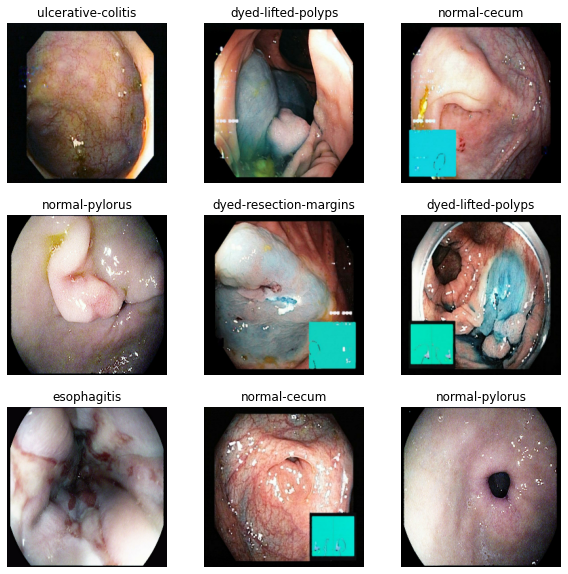

In [30]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

**Examples of augmented images:**

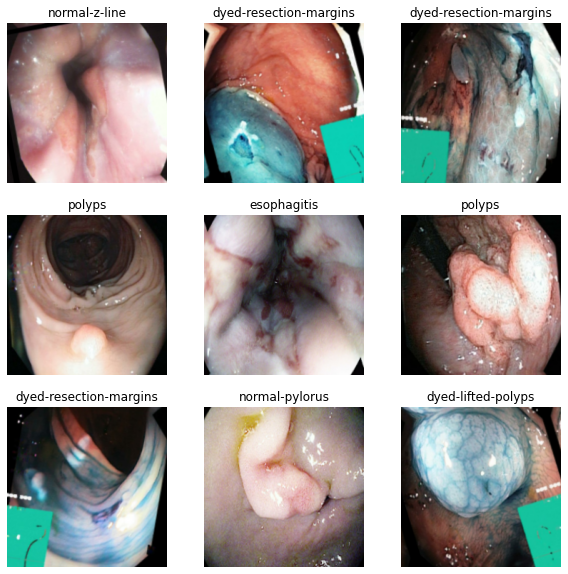

In [31]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 10))
for images, labels in train_ds_aug.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

# Prepare Test dataset

In [49]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_width, img_height),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 1600 files belonging to 8 classes.


In [50]:
test_ds_aug = augument_data1 (test_ds, img_height-20)
test_ds_norm = norm_data (test_ds_aug)

In [51]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds_norm = test_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)

In [52]:
i = 0
y = np.zeros(shape=(1600,8))
for inputs_batch, labels_batch in test_ds_norm:
  #print(inputs_batch.shape)
  y[i * batch_size : (i + 1) * batch_size] = labels_batch
  i += 1
  if i * batch_size >= 1600:
      break

In [53]:
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

# CNN Model



In [54]:

from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

num_classes = 8

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
filepath="weights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, callback]

model2 = tf.keras.Sequential([
  layers.Conv2D(64, 3, activation='relu', input_shape=(224,224,3), padding='same',
                kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(128, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(256, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.4),
  #layers.Dense(256, activation='relu'),
  #layers.Dropout(0.35),
  layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Dropout(0.4),
  layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
])

In [55]:
opt1=optimizers.RMSprop(learning_rate=2e-5)

In [56]:
opt2 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8)

In [57]:
opt3=optimizers.RMSprop(learning_rate=0.001)

In [58]:
model2.compile(
  optimizer=opt1,
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [59]:
hist_cnn_m2 = model2.fit(train_ds_norm,
  epochs=20,callbacks=[callbacks_list],
  validation_data = val_ds_norm
)

Epoch 1/20
400/400 [==============================] - ETA: 0s - loss: 1.3006 - accuracy: 0.4891
Epoch 1: val_accuracy improved from -inf to 0.59219, saving model to weights.best.hdf5
400/400 [==============================] - 1960s 5s/step - loss: 1.3006 - accuracy: 0.4891 - val_loss: 1.0068 - val_accuracy: 0.5922
Epoch 2/20
400/400 [==============================] - ETA: 0s - loss: 0.9785 - accuracy: 0.6080
Epoch 2: val_accuracy improved from 0.59219 to 0.62563, saving model to weights.best.hdf5
400/400 [==============================] - 133s 332ms/step - loss: 0.9785 - accuracy: 0.6080 - val_loss: 0.9431 - val_accuracy: 0.6256
Epoch 3/20
400/400 [==============================] - ETA: 0s - loss: 0.8781 - accuracy: 0.6542
Epoch 3: val_accuracy improved from 0.62563 to 0.65000, saving model to weights.best.hdf5
400/400 [==============================] - 134s 334ms/step - loss: 0.8781 - accuracy: 0.6542 - val_loss: 0.8615 - val_accuracy: 0.6500
Epoch 4/20
400/400 [======================

In [60]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

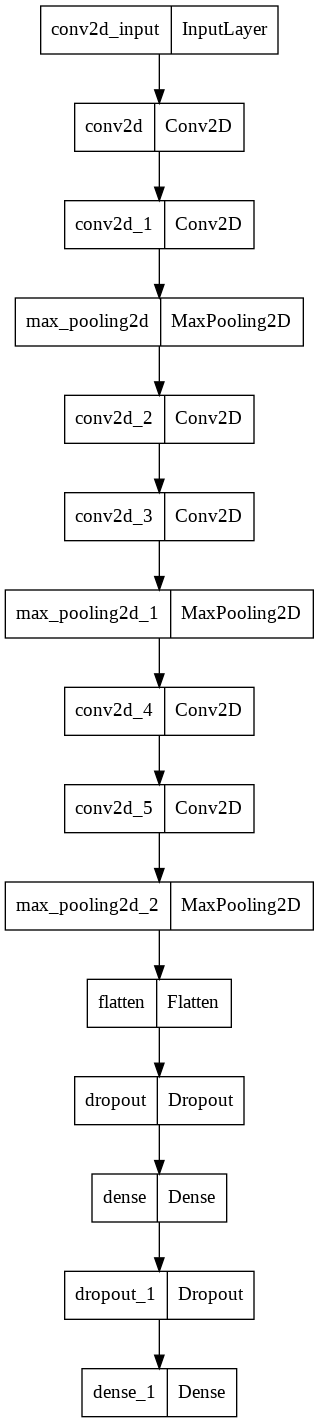

In [61]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
keras.utils.plot_model(model2, "my_first_model.png")

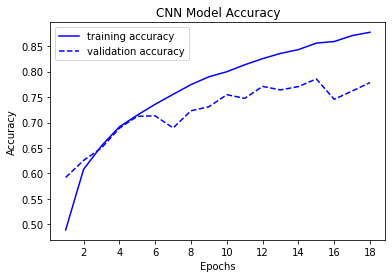

In [62]:
import matplotlib.pyplot as plt

acc = hist_cnn_m2.history['accuracy']
val_acc = hist_cnn_m2.history['val_accuracy']
loss = hist_cnn_m2.history['loss']
val_loss = hist_cnn_m2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.title('CNN Model Accuracy')
plt.plot(epochs, acc, 'b', label='training accuracy')
plt.plot(epochs, val_acc, 'b--', label='validation accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(2, len(acc)+1, 2))
plt.legend()


plt.show()

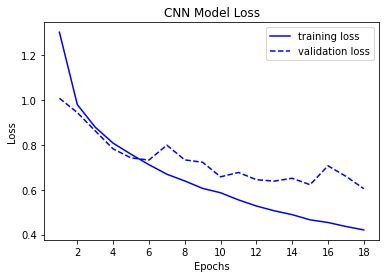

In [63]:


plt.title('CNN Model Loss')
plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'b--', label='validation loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(2, len(loss)+1, 2))
plt.legend()


plt.show()

In [65]:
hist_cnn_m2 = model2.fit(val_ds_norm,
  epochs=10,callbacks=[callbacks_list],
  validation_data = train_ds_norm
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.7622
Epoch 1: val_accuracy improved from 0.78562 to 0.91336, saving model to weights.best.hdf5
100/100 [==============================] - 73s 732ms/step - loss: 0.6665 - accuracy: 0.7622 - val_loss: 0.3888 - val_accuracy: 0.9134
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.7766
Epoch 2: val_accuracy did not improve from 0.91336
100/100 [==============================] - 72s 724ms/step - loss: 0.6164 - accuracy: 0.7766 - val_loss: 0.3902 - val_accuracy: 0.9047
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.7975
Epoch 3: val_accuracy did not improve from 0.91336
100/100 [==============================] - 71s 716ms/step - loss: 0.5876 - accuracy: 0.7975 - val_loss: 0.4100 - val_accuracy: 0.9054
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.8219
Epoch 4: val_accuracy 

In [66]:
model2.evaluate(test_ds_norm)

50/50 [==============================] - 5s 105ms/step - loss: 1.5511 - accuracy: 0.4863


[1.551068902015686, 0.48625001311302185]

In [67]:
test_pred = model2.predict(test_ds_norm)

50/50 [==============================] - 5s 102ms/step


In [68]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y[:], axis=1), np.argmax(test_pred[:], axis=1)))

              precision    recall  f1-score   support

           0       0.56      0.67      0.61       200
           1       0.75      0.43      0.55       200
           2       1.00      0.04      0.09       200
           3       0.57      0.98      0.72       200
           4       0.62      0.15      0.25       200
           5       0.48      0.73      0.58       200
           6       0.71      0.12      0.21       200
           7       0.30      0.76      0.43       200

    accuracy                           0.49      1600
   macro avg       0.62      0.49      0.43      1600
weighted avg       0.62      0.49      0.43      1600



In [69]:
"""
   The functions uses displays the confusion matrix
"""

# ----------------------------------------------------------------------
def cm_plt(ax, cm, classes, cmap, title, normalize):
    """
       displays the confusion matrix belongs to the axis between

    args:
        ax (plt): ax used to display the matrix
        cm (numpy): confusion matrix
        classes (list): list of classes
        cmap (plt): matrix color
        title (str): matrix title
        normalize (boolean): true displays cm normalized

    Returns:
        plt: the ax that will be displayed
    """
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax


# ----------------------------------------------------------------------
# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.BuPu):
    """
       display normalized and non-normalized cm

    args:
        cm (numpy): confusion matrix
        classes (list): list of classes
        fig_size(_type_):_description_
        cmap (plt, optional): flow of the matrix. Defaults to plt.cm.Blues.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )

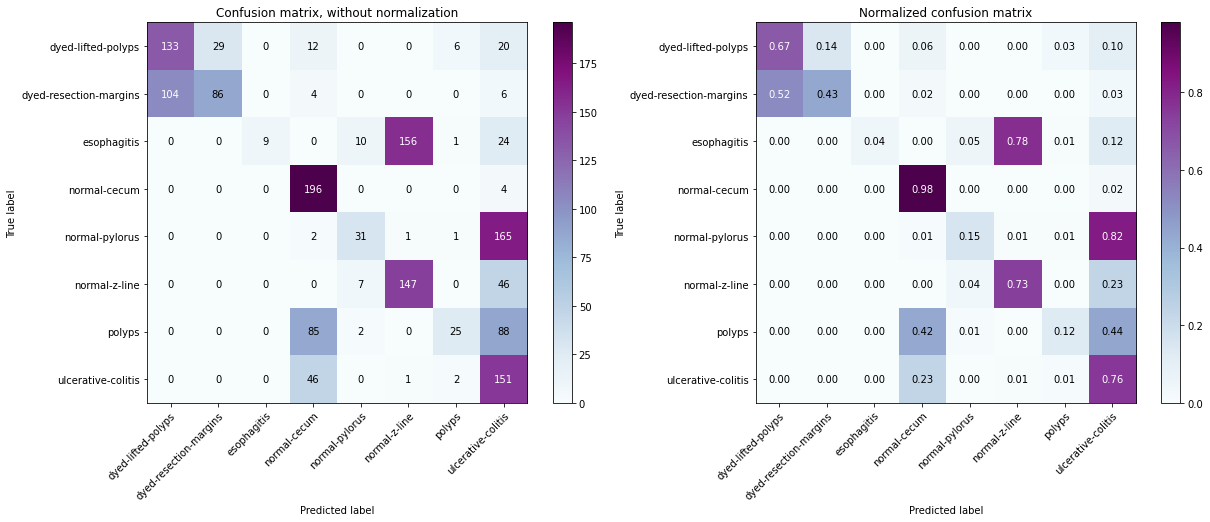

In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(test_pred, axis=1))
plt_confusion_mat(cm, classes=categories, fig_size=(20, 7))

# Hyperparameters tuning



In [71]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

In [75]:
def get_model(num_classes = 8, drop_out=0.4, reg=None, n_densenodes=256):

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, 3, activation='relu', input_shape=(224,224,3), padding='same',
                kernel_regularizer=reg))
  model.add(layers.Conv2D(64, 3, activation='relu', padding='same',
                kernel_regularizer=reg))

  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
  model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
  
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(256, 3, activation='relu',padding='same'))
  model.add(layers.Conv2D(256, 3, activation='relu',padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dropout(drop_out))

  model.add(layers.Dense(n_densenodes, activation='relu', kernel_regularizer=reg))
  model.add(layers.Dropout(drop_out))
  model.add(layers.Dense(num_classes, activation='softmax', kernel_regularizer=reg))
  
  return model

In [77]:
def optimizer_search(iters=10):
  
  opt1 = optimizers.RMSprop(learning_rate=2e-5)
  opt2 = optimizers.RMSprop(learning_rate=2e-4)
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  opt4 = optimizers.SGD(learning_rate=0.001, momentum=0.9)
  opt5 = optimizers.SGD(learning_rate=0.01, momentum=0.8)
  opt6 = optimizers.SGD(learning_rate=0.01, momentum=0.9)
  opt7 = optimizers.SGD(learning_rate=0.0001, momentum=0.8)
  opt8 = optimizers.SGD(learning_rate=0.0001, momentum=0.9)
  opt9 = optimizers.Adam()

  opt_list = [opt1, opt2, opt3, opt4, opt5, opt6, opt7, opt8, opt9]
  opt_name = ['RMSprop(learning_rate=2e-5)', 
              'RMSprop(learning_rate=2e-4)', 
              'SGD(learning_rate=0.001, momentum=0.8)',
              'SGD(learning_rate=0.001, momentum=0.9)',
              'SGD(learning_rate=0.01, momentum=0.8)',
              'SGD(learning_rate=0.01, momentum=0.9)',
              'SGD(learning_rate=0.0001, momentum=0.8)',
              'SGD(learning_rate=0.0001, momentum=0.9)',
              'adam']
  opt_hist=[]

  # regularizers.l2(1e-4)

  # 1. pick optimizer
  
  
  for i, opt in enumerate(opt_list):
    print(opt_name[i])
    model = get_model()
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
    h = model.fit(train_ds_norm, epochs=15, validation_data = val_ds_norm)
    opt_hist.append(h)
    print("")
  
  return opt_hist, opt_name



  """
  for m in momentums:
    model = get_model()
    opt = tf.keras.optimizers.SGD(lr=best_lr, momentum = m)
    model.compile(optimizer=opt,
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.fit(normtrain_ds ,epochs=iters)
    score = model.evaluate(normval_ds, verbose=0)
    if score[1] > best_acc:
      best_acc = score[1]
      best_mom = m

  print('best lr: ', best_lr)
  print('best momentum: ', best_mom)"""

  


In [78]:
opt_hist = optimizer_search()

RMSprop(learning_rate=2e-5)
Epoch 1/15
400/400 [==============================] - 132s 328ms/step - loss: 1.1762 - accuracy: 0.4958 - val_loss: 0.8671 - val_accuracy: 0.6141
Epoch 2/15
400/400 [==============================] - 132s 330ms/step - loss: 0.8641 - accuracy: 0.6136 - val_loss: 0.7828 - val_accuracy: 0.6472
Epoch 3/15
400/400 [==============================] - 132s 330ms/step - loss: 0.7723 - accuracy: 0.6621 - val_loss: 0.7985 - val_accuracy: 0.6478
Epoch 4/15
400/400 [==============================] - 132s 330ms/step - loss: 0.6974 - accuracy: 0.6970 - val_loss: 0.7123 - val_accuracy: 0.6747
Epoch 5/15
400/400 [==============================] - 132s 330ms/step - loss: 0.6469 - accuracy: 0.7244 - val_loss: 0.6491 - val_accuracy: 0.7081
Epoch 6/15
400/400 [==============================] - 132s 330ms/step - loss: 0.6018 - accuracy: 0.7477 - val_loss: 0.6270 - val_accuracy: 0.7144
Epoch 7/15
400/400 [==============================] - 132s 330ms/step - loss: 0.5634 - accuracy:

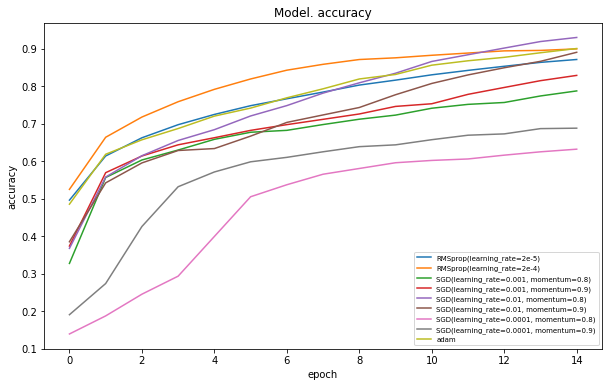

In [79]:
plt.figure(figsize=(10, 6))  



plt.plot(opt_hist[0][0].history['accuracy'])
plt.plot(opt_hist[0][1].history['accuracy'])
plt.plot(opt_hist[0][2].history['accuracy'])
plt.plot(opt_hist[0][3].history['accuracy'])
plt.plot(opt_hist[0][4].history['accuracy'])
plt.plot(opt_hist[0][5].history['accuracy'])
plt.plot(opt_hist[0][6].history['accuracy'])
plt.plot(opt_hist[0][7].history['accuracy'])
plt.plot(opt_hist[0][8].history['accuracy'])


plt.title('Model. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend([opt_hist[1][0],opt_hist[1][1],opt_hist[1][2],opt_hist[1][3],opt_hist[1][4],opt_hist[1][5],opt_hist[1][6],opt_hist[1][7],opt_hist[1][8]], loc='best', fontsize = 'x-small')  

plt.show()


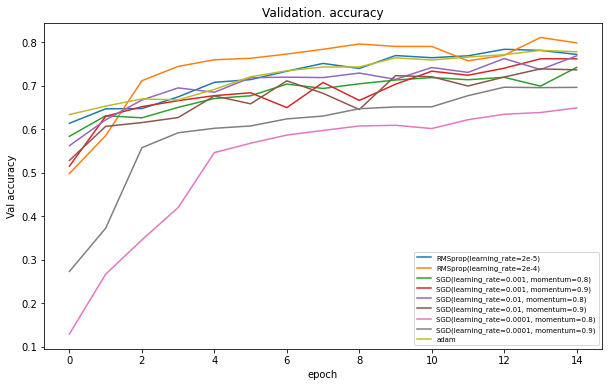

In [80]:
plt.figure(figsize=(10, 6))  

plt.plot(opt_hist[0][0].history['val_accuracy'])
plt.plot(opt_hist[0][1].history['val_accuracy'])
plt.plot(opt_hist[0][2].history['val_accuracy'])
plt.plot(opt_hist[0][3].history['val_accuracy'])
plt.plot(opt_hist[0][4].history['val_accuracy'])
plt.plot(opt_hist[0][5].history['val_accuracy'])
plt.plot(opt_hist[0][6].history['val_accuracy'])
plt.plot(opt_hist[0][7].history['val_accuracy'])
plt.plot(opt_hist[0][8].history['val_accuracy'])

plt.title('Validation. accuracy')  
plt.ylabel('Val accuracy')  
plt.xlabel('epoch')  
plt.legend([opt_hist[1][0],opt_hist[1][1],opt_hist[1][2],opt_hist[1][3],opt_hist[1][4],opt_hist[1][5],opt_hist[1][6],opt_hist[1][7],opt_hist[1][8]], loc='best', fontsize = 'x-small')  

plt.show()


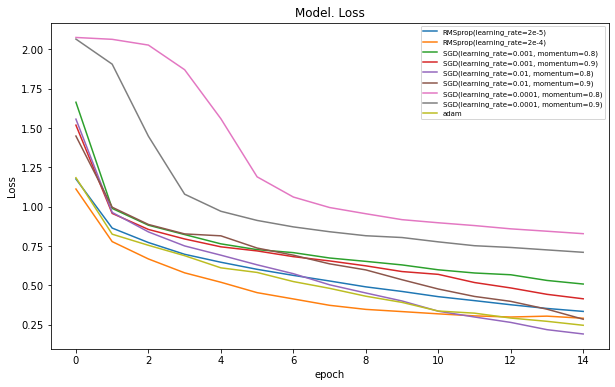

In [81]:
plt.figure(figsize=(10, 6))  


plt.plot(opt_hist[0][0].history['loss'])
plt.plot(opt_hist[0][1].history['loss'])
plt.plot(opt_hist[0][2].history['loss'])
plt.plot(opt_hist[0][3].history['loss'])
plt.plot(opt_hist[0][4].history['loss'])
plt.plot(opt_hist[0][5].history['loss'])
plt.plot(opt_hist[0][6].history['loss'])
plt.plot(opt_hist[0][7].history['loss'])
plt.plot(opt_hist[0][8].history['loss'])

plt.title('Model. Loss')  
plt.ylabel('Loss')  
plt.xlabel('epoch')  
plt.legend([opt_hist[1][0],opt_hist[1][1],opt_hist[1][2],opt_hist[1][3],opt_hist[1][4],opt_hist[1][5],opt_hist[1][6],opt_hist[1][7],opt_hist[1][8]], loc='best', fontsize = 'x-small')  

plt.show()


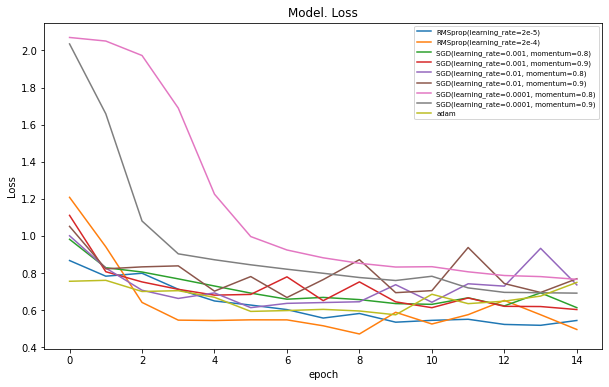

In [82]:
plt.figure(figsize=(10, 6))  



plt.plot(opt_hist[0][0].history['val_loss'])
plt.plot(opt_hist[0][1].history['val_loss'])
plt.plot(opt_hist[0][2].history['val_loss'])
plt.plot(opt_hist[0][3].history['val_loss'])
plt.plot(opt_hist[0][4].history['val_loss'])
plt.plot(opt_hist[0][5].history['val_loss'])
plt.plot(opt_hist[0][6].history['val_loss'])
plt.plot(opt_hist[0][7].history['val_loss'])
plt.plot(opt_hist[0][8].history['val_loss'])

plt.title('Model. Loss')  
plt.ylabel('Loss')  
plt.xlabel('epoch')  
plt.legend([opt_hist[1][0],opt_hist[1][1],opt_hist[1][2],opt_hist[1][3],opt_hist[1][4],opt_hist[1][5],opt_hist[1][6],opt_hist[1][7],opt_hist[1][8]], loc='best', fontsize = 'x-small')  

plt.show()


In [83]:

def reguralizer_search(iters=10):
  
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  reg1 = regularizers.l2(1e-4)
  reg2 = regularizers.l1(1e-5)
  reg3 = regularizers.l2(1e-5)
  reg4 = regularizers.l2(1e-3)

  reg_list = [reg1, reg2, reg3, reg4]
  reg_name = ['regularizers.l2(1e-4)', 
              'regularizers.l1(1e-5)', 
              'regularizers.l2(1e-5)',
              'regularizers.l2(1e-3)']
  reg_hist=[]

  # regularizers.l2(1e-4)

  # 2. pick regularizer
  for i, r in enumerate(reg_list):
    print(reg_name[i])
    model = get_model(reg=r)
    model.compile(optimizer=opt3, loss="categorical_crossentropy", metrics=['accuracy'])
    h = model.fit(train_ds_norm, epochs=15, validation_data = val_ds_norm,callbacks=[callbacks_list])
    reg_hist.append(h)
    print("")
  
  return reg_hist, reg_name



In [84]:
reg_hist = reguralizer_search()

regularizers.l2(1e-4)
Epoch 1/15
400/400 [==============================] - ETA: 0s - loss: 1.5997 - accuracy: 0.3754
Epoch 1: val_accuracy did not improve from 0.91336
400/400 [==============================] - 129s 321ms/step - loss: 1.5997 - accuracy: 0.3754 - val_loss: 1.0098 - val_accuracy: 0.5997
Epoch 2/15
400/400 [==============================] - ETA: 0s - loss: 1.0412 - accuracy: 0.5628
Epoch 2: val_accuracy did not improve from 0.91336
400/400 [==============================] - 128s 321ms/step - loss: 1.0412 - accuracy: 0.5628 - val_loss: 0.8950 - val_accuracy: 0.6353
Epoch 3/15
400/400 [==============================] - ETA: 0s - loss: 0.9390 - accuracy: 0.6016
Epoch 3: val_accuracy did not improve from 0.91336
400/400 [==============================] - 128s 321ms/step - loss: 0.9390 - accuracy: 0.6016 - val_loss: 0.8527 - val_accuracy: 0.6459
Epoch 4/15
400/400 [==============================] - ETA: 0s - loss: 0.8768 - accuracy: 0.6333
Epoch 4: val_accuracy did not improv

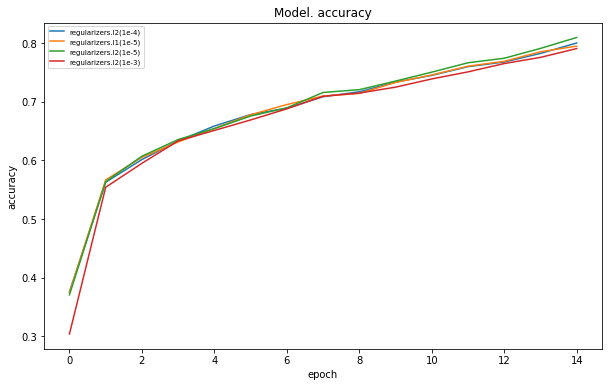

In [85]:
plt.figure(figsize=(10, 6))  



plt.plot(reg_hist[0][0].history['accuracy'])
plt.plot(reg_hist[0][1].history['accuracy'])
plt.plot(reg_hist[0][2].history['accuracy'])
plt.plot(reg_hist[0][3].history['accuracy'])



plt.title('Model. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend([reg_hist[1][0],reg_hist[1][1],reg_hist[1][2],reg_hist[1][3]], loc='best', fontsize = 'x-small')  

plt.show()


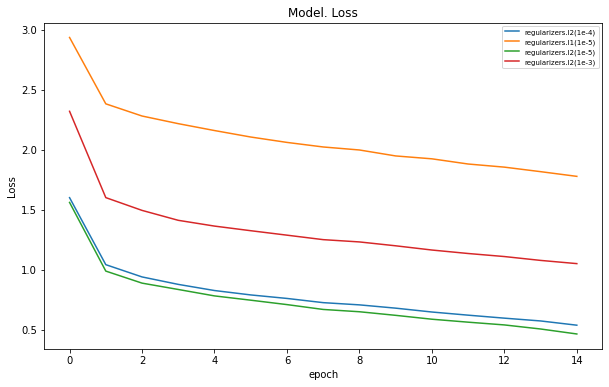

In [86]:
plt.figure(figsize=(10, 6))  



plt.plot(reg_hist[0][0].history['loss'])
plt.plot(reg_hist[0][1].history['loss'])
plt.plot(reg_hist[0][2].history['loss'])
plt.plot(reg_hist[0][3].history['loss'])



plt.title('Model. Loss')  
plt.ylabel('Loss')  
plt.xlabel('epoch')  
plt.legend([reg_hist[1][0],reg_hist[1][1],reg_hist[1][2],reg_hist[1][3]], loc='best', fontsize = 'x-small')  

plt.show()


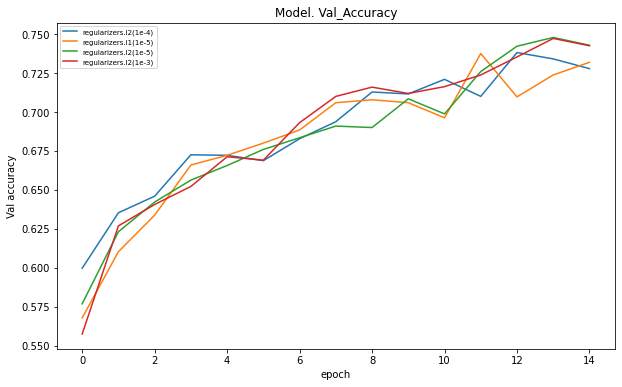

In [87]:
plt.figure(figsize=(10, 6))  



plt.plot(reg_hist[0][0].history['val_accuracy'])
plt.plot(reg_hist[0][1].history['val_accuracy'])
plt.plot(reg_hist[0][2].history['val_accuracy'])
plt.plot(reg_hist[0][3].history['val_accuracy'])



plt.title('Model. Val_Accuracy')  
plt.ylabel('Val accuracy')  
plt.xlabel('epoch')  
plt.legend([reg_hist[1][0],reg_hist[1][1],reg_hist[1][2],reg_hist[1][3]], loc='best', fontsize = 'x-small')  

plt.show()


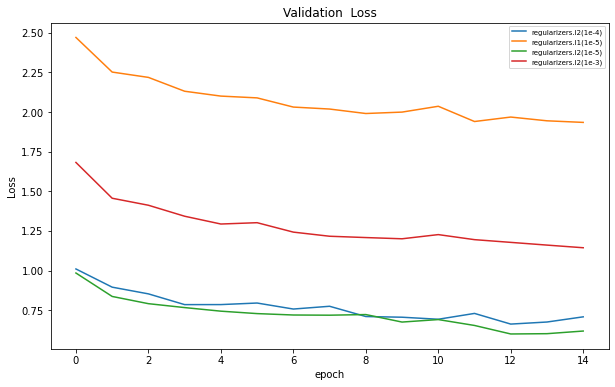

In [88]:
plt.figure(figsize=(10, 6))  



plt.plot(reg_hist[0][0].history['val_loss'])
plt.plot(reg_hist[0][1].history['val_loss'])
plt.plot(reg_hist[0][2].history['val_loss'])
plt.plot(reg_hist[0][3].history['val_loss'])



plt.title('Validation  Loss')  
plt.ylabel('Loss')  
plt.xlabel('epoch')  
plt.legend([reg_hist[1][0],reg_hist[1][1],reg_hist[1][2],reg_hist[1][3]], loc='best', fontsize = 'x-small')  

plt.show()


# Learn and extract image features

## VGG16

In [89]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

In [90]:


# load model without classifier layers
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
drop1 = layers.Dropout(0.4)(flat1)
class1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(drop1)
drop2 = layers.Dropout(0.4)(class1)
output = Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(drop2)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [91]:
opt1 = optimizers.SGD(learning_rate=0.01, momentum=0.8)
opt2 = optimizers.RMSprop(learning_rate=2e-5)
opt3="adam"

In [92]:
model.compile(
  optimizer=opt2,
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [93]:
history1 = model.fit(
  train_ds_norm,
  epochs=20,
  validation_data = val_ds_norm
)

Epoch 1/20
400/400 [==============================] - 195s 480ms/step - loss: 1.0742 - accuracy: 0.5952 - val_loss: 0.4395 - val_accuracy: 0.8500
Epoch 2/20
400/400 [==============================] - 193s 481ms/step - loss: 0.4790 - accuracy: 0.8339 - val_loss: 0.4154 - val_accuracy: 0.8528
Epoch 3/20
400/400 [==============================] - 192s 481ms/step - loss: 0.3409 - accuracy: 0.8838 - val_loss: 0.2572 - val_accuracy: 0.9153
Epoch 4/20
400/400 [==============================] - 193s 482ms/step - loss: 0.2577 - accuracy: 0.9155 - val_loss: 0.3381 - val_accuracy: 0.8969
Epoch 5/20
400/400 [==============================] - 193s 481ms/step - loss: 0.2029 - accuracy: 0.9348 - val_loss: 0.2310 - val_accuracy: 0.9325
Epoch 6/20
400/400 [==============================] - 193s 482ms/step - loss: 0.1698 - accuracy: 0.9531 - val_loss: 0.2518 - val_accuracy: 0.9269
Epoch 7/20
400/400 [==============================] - 193s 482ms/step - loss: 0.1376 - accuracy: 0.9645 - val_loss: 0.2185 -

In [94]:
model.fit(train_all_norm,
          epochs=14)

Epoch 1/14
500/500 [==============================] - 270s 538ms/step - loss: 0.1045 - accuracy: 0.9707
Epoch 2/14
500/500 [==============================] - 221s 442ms/step - loss: 0.0864 - accuracy: 0.9791
Epoch 3/14
500/500 [==============================] - 221s 441ms/step - loss: 0.0710 - accuracy: 0.9829
Epoch 4/14
500/500 [==============================] - 220s 441ms/step - loss: 0.0651 - accuracy: 0.9858
Epoch 5/14
500/500 [==============================] - 221s 441ms/step - loss: 0.0698 - accuracy: 0.9837
Epoch 6/14
500/500 [==============================] - 221s 441ms/step - loss: 0.0590 - accuracy: 0.9862
Epoch 7/14
500/500 [==============================] - 220s 440ms/step - loss: 0.0610 - accuracy: 0.9880
Epoch 8/14
500/500 [==============================] - 220s 440ms/step - loss: 0.0552 - accuracy: 0.9885
Epoch 9/14
500/500 [==============================] - 220s 440ms/step - loss: 0.0524 - accuracy: 0.9898
Epoch 10/14
500/500 [==============================] - 220s 440m

In [95]:
model.save("vgg16.h5")

In [96]:
from keras.models import load_model

In [97]:
model_vgg = load_model('vgg16.h5')

In [98]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [99]:
vgg_features_model = Model (model_vgg.layers[0].input,  model_vgg.layers[21].output)

In [100]:
vgg_features_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [101]:
model_vgg.evaluate(test_ds_norm)

50/50 [==============================] - 8s 157ms/step - loss: 1.0068 - accuracy: 0.8350


[1.0068261623382568, 0.8349999785423279]

In [102]:
predict_test = model_vgg.predict(test_ds_norm)

50/50 [==============================] - 8s 154ms/step


In [103]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y, axis=1), np.argmax(predict_test, axis=1)))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       200
           1       0.95      0.87      0.91       200
           2       0.86      0.52      0.64       200
           3       0.91      0.86      0.89       200
           4       0.92      0.92      0.92       200
           5       0.67      0.84      0.75       200
           6       0.86      0.84      0.85       200
           7       0.72      0.98      0.83       200

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.83      1600
weighted avg       0.85      0.83      0.83      1600



In [104]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average='weighted')

0.8487118920138886

In [105]:
np.average(recall_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average=None))

0.835

In [106]:
np.average(f1_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average=None))

0.8323121568258676

In [107]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(predict_test, axis=1))


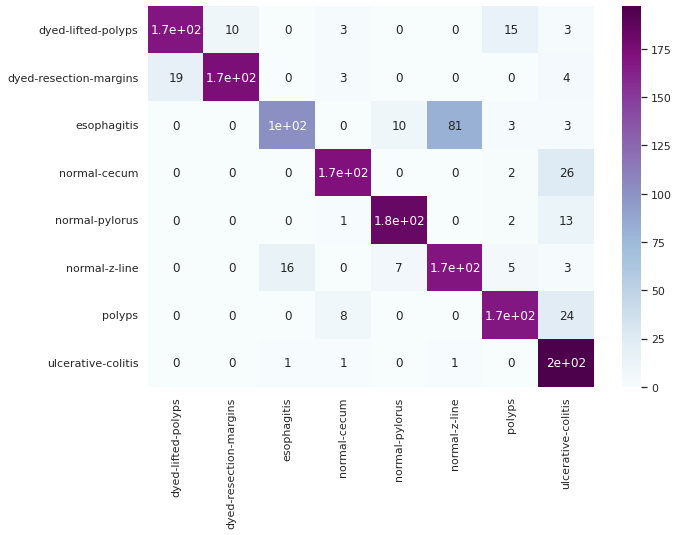

In [108]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu") # font size

plt.show()

In [109]:
df_cm

,dyed-lifted-polyps,dyed-resection-margins,esophagitis,normal-cecum,normal-pylorus,normal-z-line,polyps,ulcerative-colitis
dyed-lifted-polyps,169,10,0,3,0,0,15,3
dyed-resection-margins,19,174,0,3,0,0,0,4
esophagitis,0,0,103,0,10,81,3,3
normal-cecum,0,0,0,172,0,0,2,26
normal-pylorus,0,0,0,1,184,0,2,13
normal-z-line,0,0,16,0,7,169,5,3
polyps,0,0,0,8,0,0,168,24
ulcerative-colitis,0,0,1,1,0,1,0,197


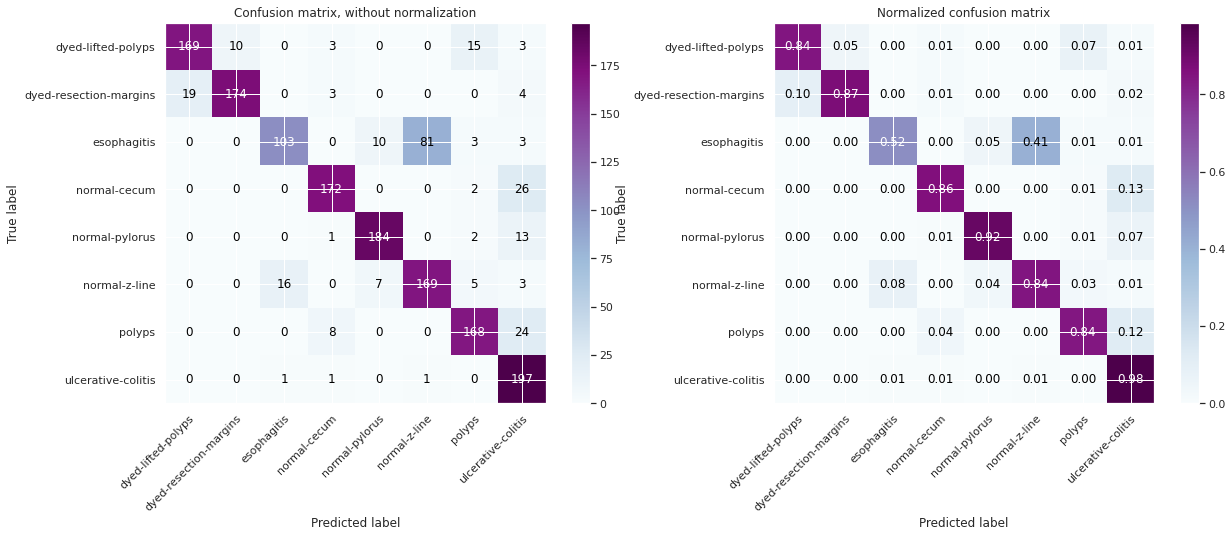

In [110]:
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(predict_test, axis=1))
plt_confusion_mat(cm, classes=class_names, fig_size=(20, 7))

## DenseNet-169

In [111]:
from keras.applications.densenet import DenseNet169
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers

# load model without classifier layers
model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
drop1 = layers.Dropout(0.5)(flat1)
class1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(drop1)
drop2 = layers.Dropout(0.5)(class1)
output = Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(drop2)

# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

51877672/51877672 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

In [112]:
model.compile(
  optimizer=optimizers.RMSprop(learning_rate=2e-5),
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [ ]:
history3 = model.fit(
  train_ds_norm,
  epochs=20,
  validation_data = val_ds_norm
)

Epoch 1/20
400/400 [==============================] - 225s 484ms/step - loss: 1.1766 - accuracy: 0.6134 - val_loss: 0.3501 - val_accuracy: 0.8816
Epoch 2/20
400/400 [==============================] - 190s 476ms/step - loss: 0.3967 - accuracy: 0.8674 - val_loss: 0.2538 - val_accuracy: 0.9256
Epoch 3/20
400/400 [==============================] - 191s 476ms/step - loss: 0.2183 - accuracy: 0.9335 - val_loss: 0.2205 - val_accuracy: 0.9450
Epoch 4/20
400/400 [==============================] - 190s 476ms/step - loss: 0.1296 - accuracy: 0.9636 - val_loss: 0.2197 - val_accuracy: 0.9563
Epoch 5/20
400/400 [==============================] - 190s 476ms/step - loss: 0.0809 - accuracy: 0.9816 - val_loss: 0.2728 - val_accuracy: 0.9494
Epoch 6/20
400/400 [==============================] - 191s 476ms/step - loss: 0.0578 - accuracy: 0.9893 - val_loss: 0.2857 - val_accuracy: 0.9541
Epoch 7/20
400/400 [==============================] - 190s 476ms/step - loss: 0.0463 - accuracy: 0.9925 - val_loss: 0.2897 -

In [ ]:
model.fit(train_all_norm,
          epochs=17)

In [ ]:
model.evaluate(test_ds_norm)

In [ ]:
predict_test = model.predict(test_ds_norm)

In [ ]:
predict_test.shape

In [ ]:
model.save("densenet.h5")

In [ ]:
from keras.models import load_model
model_dn = load_model('densenet.h5')

In [ ]:
model_dn.summary ()

In [ ]:
dn_features_model = Model (model_dn.layers[0].input,  model_dn.layers[597].output)

In [ ]:
dn_features_model.summary()

In [ ]:
pred_test = model.predict(test_ds_norm)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
np.average(precision_score(np.argmax(y, axis=1), np.argmax(pred_test, axis=1), average='weighted'))

In [ ]:
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(predict_test, axis=1))
#cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1))
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(pred_test, axis=1))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu") # font size

plt.show()

# Save features to pickle file for future use

In [ ]:
import pandas as pd

In [ ]:
vgg_features = vgg_features_model.predict(train_ds_norm)
vgg_features_val = vgg_features_model.predict(val_ds_norm)
vgg_features_test = vgg_features_model.predict(test_ds_norm)

In [ ]:
df_features = pd.DataFrame(vgg_features)
df_features.to_pickle("vgg_features.pkl")
df_features = pd.DataFrame(vgg_features_val)
df_features.to_pickle("vgg_features_val.pkl")
df_features = pd.DataFrame(vgg_features_test)
df_features.to_pickle("vgg_features_test.pkl")

In [ ]:
dn_features = dn_features_model.predict(train_ds_norm)
dn_features_val = dn_features_model.predict(val_ds_norm)
dn_features_test = dn_features_model.predict(test_ds_norm)

In [ ]:
y_train = np.concatenate([y for x, y in train_ds_norm], axis=0)
y_val = np.concatenate([y for x, y in val_ds_norm], axis=0)
y_test = np.concatenate([y for x, y in test_ds_norm], axis=0)

In [ ]:
df_features = pd.DataFrame(dn_features)
df_features["label"] = np.argmax(y_train, axis=1)
df_features.to_pickle("dn_features.pkl")

df_features = pd.DataFrame(dn_features_val)
df_features["label"] = np.argmax(y_val, axis=1)
df_features.to_pickle("dn_features_val.pkl")

df_features = pd.DataFrame(dn_features_test)
df_features["label"] = np.argmax(y_test, axis=1)
df_features.to_pickle("dn_features_test.pkl")

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
vgg_features = np.array(pd.read_pickle("vgg_features.pkl"))
dn_features = np.array(pd.read_pickle("dn_features.pkl"))
vgg_features_val = np.array(pd.read_pickle("vgg_features_val.pkl"))
dn_features_val = np.array(pd.read_pickle("dn_features_val.pkl"))
vgg_features_test = np.array(pd.read_pickle("vgg_features_test.pkl"))
dn_features_test = np.array(pd.read_pickle("dn_features_test.pkl"))

In [ ]:
# extract class labels
y_train = dn_features[:,-1]
y_val = dn_features_val[:,-1]
y_test = dn_features_test[:,-1]

In [ ]:
dn_features_val = dn_features_val[:,:-1]
dn_features = dn_features[:,:-1]
dn_features_test = dn_features_test[:,:-1]

In [ ]:
combined_features = np.concatenate ((dn_features, vgg_features), axis=1)
combined_features_val = np.concatenate ((dn_features_val, vgg_features_val), axis=1)
combined_features_test = np.concatenate ((dn_features_test, vgg_features_test), axis=1)

In [ ]:
# 256 features from VGG16 + 256 features from DenseNet169
print ("combined_features.shape: ", combined_features.shape)
print ("combined_features_val.shape: ", combined_features_val.shape)
print ("combined_features_test.shape: ", combined_features_test.shape)

In [ ]:
import time
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

In [ ]:
feat_cols = [ 'pixel'+str(i) for i in range(combined_features.shape[1]) ]
df = pd.DataFrame(combined_features,columns=feat_cols)
df['class'] = y_train
df['label'] = df['class'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=5000)
tsne_results = tsne.fit_transform(df[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 8),
    data=df,
    legend="full",
    alpha=0.3
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
lr = LogisticRegression(max_iter=10000)

In [ ]:
combined_features_all = np.concatenate((combined_features, combined_features_val))
y_train_all = np.concatenate((y_train, y_val))

In [ ]:
combined_features_all.shape

In [ ]:
y_train_all.shape

In [ ]:
lr.fit(combined_features, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

# training set accuracy
y_pred = lr.predict(combined_features_test)
accuracy_score( y_test, y_pred)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
precision_score(y_test, y_pred, average="weighted")

In [ ]:
recall_score(y_test, y_pred, average="weighted")

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
cm

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
class_names = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="BuPu") # font size

plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier()
mlp.fit(combined_features, y_train)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(combined_features, y_train)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(combined_features, y_train)

In [ ]:
pred_test1 = neigh.predict(combined_features_test)

In [ ]:
pred_test2 = dt.predict(combined_features_test)

In [ ]:
pred_test3 = mlp.predict(combined_features_test)

In [ ]:
accuracy_score(y_test, pred_test1) # KNeighborsClassifier accuracy

In [ ]:
accuracy_score(y_test, pred_test2) # DecisionTreeClassifier accuracy

In [ ]:
accuracy_score(y_test, pred_test3) # MLP classifier accuracy